In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
df = pd.read_csv('train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Determine empty columns

In [19]:
empty_cols = df.isnull().sum()
empty_cols

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Define features and label (X, y)

In [20]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
X = df[features]
y = df.Survived

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# Split data to prevent leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=1)

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

In [24]:
# Separate columns
num_features = ['Age', 'Fare']
cat_features = ['Pclass', 'Sex', 'Embarked']

In [25]:
# Numerical pipeline
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# Categorical pipeline
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

In [26]:
# Combine into a column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [27]:
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=1))
])

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
param_grid = {
    'classifier__max_depth' : [3, 5, 7, 9, None],
    'classifier__min_samples_split' : [10, 16, 20],
    'classifier__min_samples_leaf' : [5, 8, 10]
}

In [31]:
grid_search = GridSearchCV(
    clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=1 # Use all CPU cores
)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Pclass',
                                                                          'Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        DecisionTreeClassifier(random_state=1))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [3, 5, 7, 9, None],
                         'classifier__min_samples_leaf': [5, 8, 10],
                         'classifier__min_samples_split': [10, 16, 20]},
             scoring='accuracy')

In [32]:
print("Best params:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

Best params: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 10}
Best CV score: 0.8287008765882007


In [33]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [36]:
from sklearn.metrics import accuracy_score

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7877


In [38]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
print(confusion_matrix(y_test, y_pred))

[[98  8]
 [30 43]]


In [40]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       106
           1       0.84      0.59      0.69        73

    accuracy                           0.79       179
   macro avg       0.80      0.76      0.77       179
weighted avg       0.80      0.79      0.78       179



Visualize the tree

In [41]:
from sklearn.tree import plot_tree

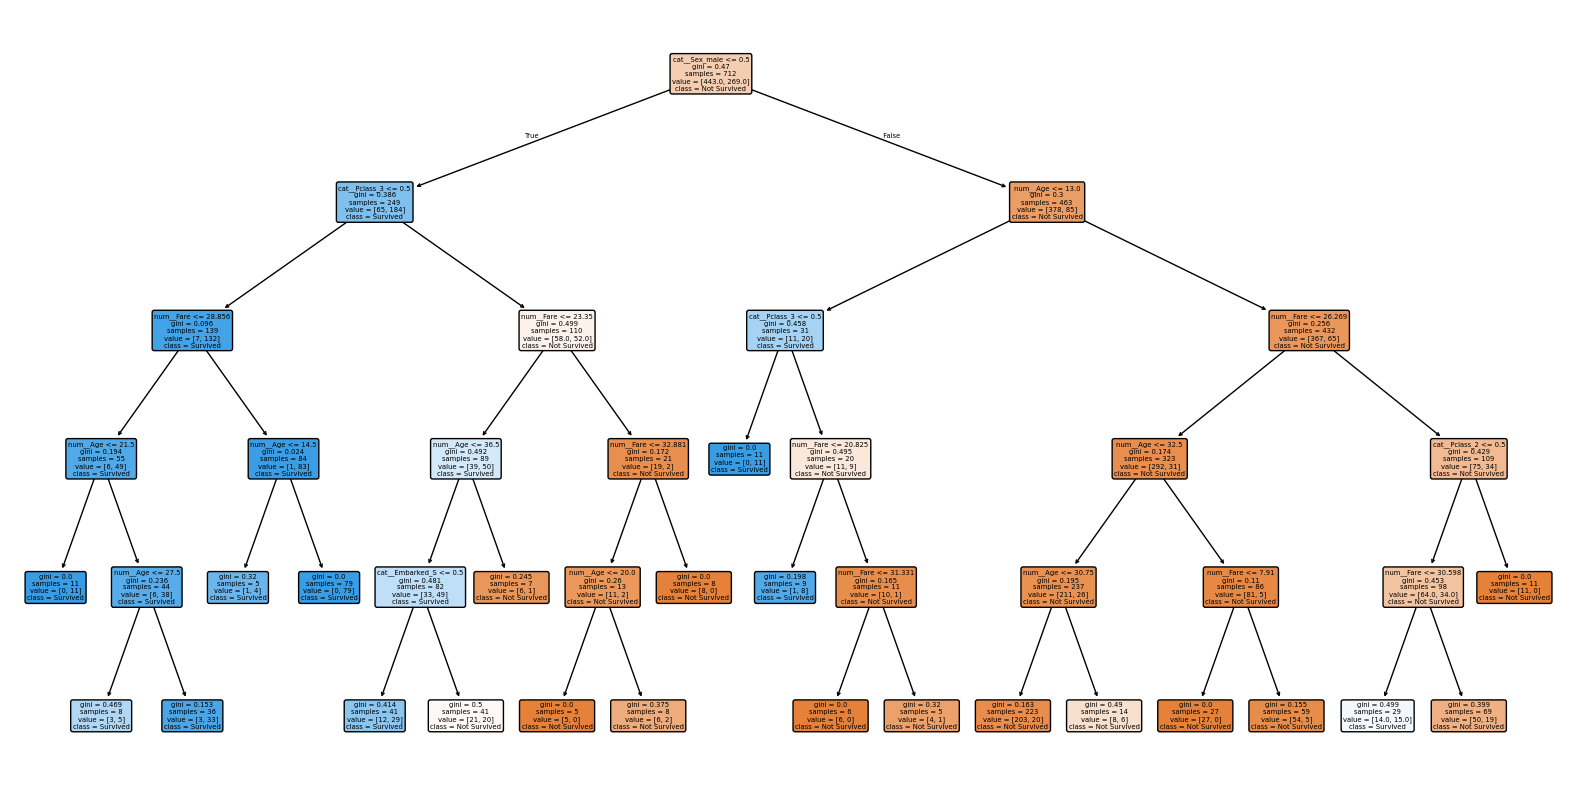

In [42]:
plt.figure(figsize=(20,10)) 
plot_tree(
    best_model.named_steps['classifier'],
    feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(),
    class_names=['Not Survived', 'Survived'],
    filled=True,
    rounded=True
)
plt.show()